# Figure 3: First melt season after doline formation (2019/2020)

a) Landsat-8 image 29 January 2020 #126/111; ICESat-2 Tracks 0523 GT3L and GT3R are shown; (b and c) zooms of Landsat-8 image; ICESat-2 ATL03 and ATL06 data (d and e) for Track 0523 GT3L and GT3R across a drainage channel (at -72.378 \deg) incised by meltwater flow from the rebound lake to the doline; f) for Track 0523 GT3R across the doline in January and April 2020 showing the structure of the collapsed ice lid and meltwater. The April track is displaced to align major features with the January profile.

In [1]:
%matplotlib notebook
import rasterio as rio
from rasterio import plot
from rasterio import warp
from rasterio import Affine as A
from rasterio.enums import ColorInterp
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio.transform import TransformMethodsMixin
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.crs import CRS
import os
from os import listdir, makedirs
from os.path import isfile, join, exists
# needed to set environment variables to make it work
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import pandas as pd
import geopandas as gpd
import numpy as np
import earthpy as et
import earthpy.spatial as es
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle as pkl
from mpl_toolkits.basemap import Basemap
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.read_ICESat2_ATL06 import read_HDF5_ATL06
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=RuntimeWarning)
from matplotlib.ticker import FormatStrFormatter
from curve_intersect import *
import shapely
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from scipy import ndimage, misc

## pull the data together

In [2]:
loadpickle = False
data_dir = 'data/IS2/'
pklfn = 'compiledIS2dataFig3.pkl'
dates = ['20200129', '20200429']
beams = ['gt3r', 'gt3l']

if loadpickle:
    with open(data_dir + pklfn, 'rb') as f:
        dfs6, dfs3 = pkl.load(f)
    
else:
    atl06files = ['processed_ATL06_20200129235823_05230610_003_01.h5', 'processed_ATL06_20200429193808_05230710_003_02.h5']
    atl03files = ['processed_ATL03_20200129235823_05230610_003_01.h5', 'processed_ATL03_20200429193808_05230710_003_01.h5']
    latmin = -72.5
    latmax = -72.2

    dfs6 = []
    dfs3 = []
    for i,date in enumerate(dates):

        atl06file = atl06files[i]
        atl03file = atl03files[i]
        IS2_atl06_mds, IS2_atl06_attrs, IS2_atl06_beams = read_HDF5_ATL06(data_dir+atl06file)
        IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(data_dir+atl03file)

        for j,beam in enumerate(beams):

            data06 = IS2_atl06_mds[beam]
            lat_gt = data06['land_ice_segments']['latitude']
            lon_gt = data06['land_ice_segments']['longitude']
            h06 = data06['land_ice_segments']['h_li']
            h06[h06>1e5] = np.nan
            df06 = pd.DataFrame(list(zip(lat_gt,lon_gt,h06)),columns=['lat','lon','h'])
            keep = (df06.lat > latmin) & (df06.lat < latmax)
            df06 = df06[keep].copy()
            coords_transf = warp.transform({'init': 'epsg:4326'}, CRS.from_string('EPSG:3031'), 
                                           np.array(df06.lon), np.array(df06.lat))
            df06['x_img'] = coords_transf[0]
            df06['y_img'] = coords_transf[1]
            df06.sort_values(by='lat',inplace=True)
            dfs6.append(df06)

            data03 = IS2_atl03_mds[beam]
            lat = data03['heights']['lat_ph']
            lon = data03['heights']['lon_ph']
            h = data03['heights']['h_ph']
            conf = data03['heights']['signal_conf_ph']
            landice = 3  # land ice is fourth column of confidence array
            conf = conf[:, landice]
            df03 = pd.DataFrame(list(zip(lat,lon,h,conf)),columns=['lat','lon','h','conf'])
            keep = (df03.lat > latmin) & (df03.lat < latmax)
            df03 = df03[keep].copy()
            df03.sort_values(by='lat',inplace=True)
            dfs3.append(df03)

    with open(data_dir + pklfn, 'wb') as f:
        pkl.dump([dfs6, dfs3], f)

## make the figure

<IPython.core.display.Javascript object>


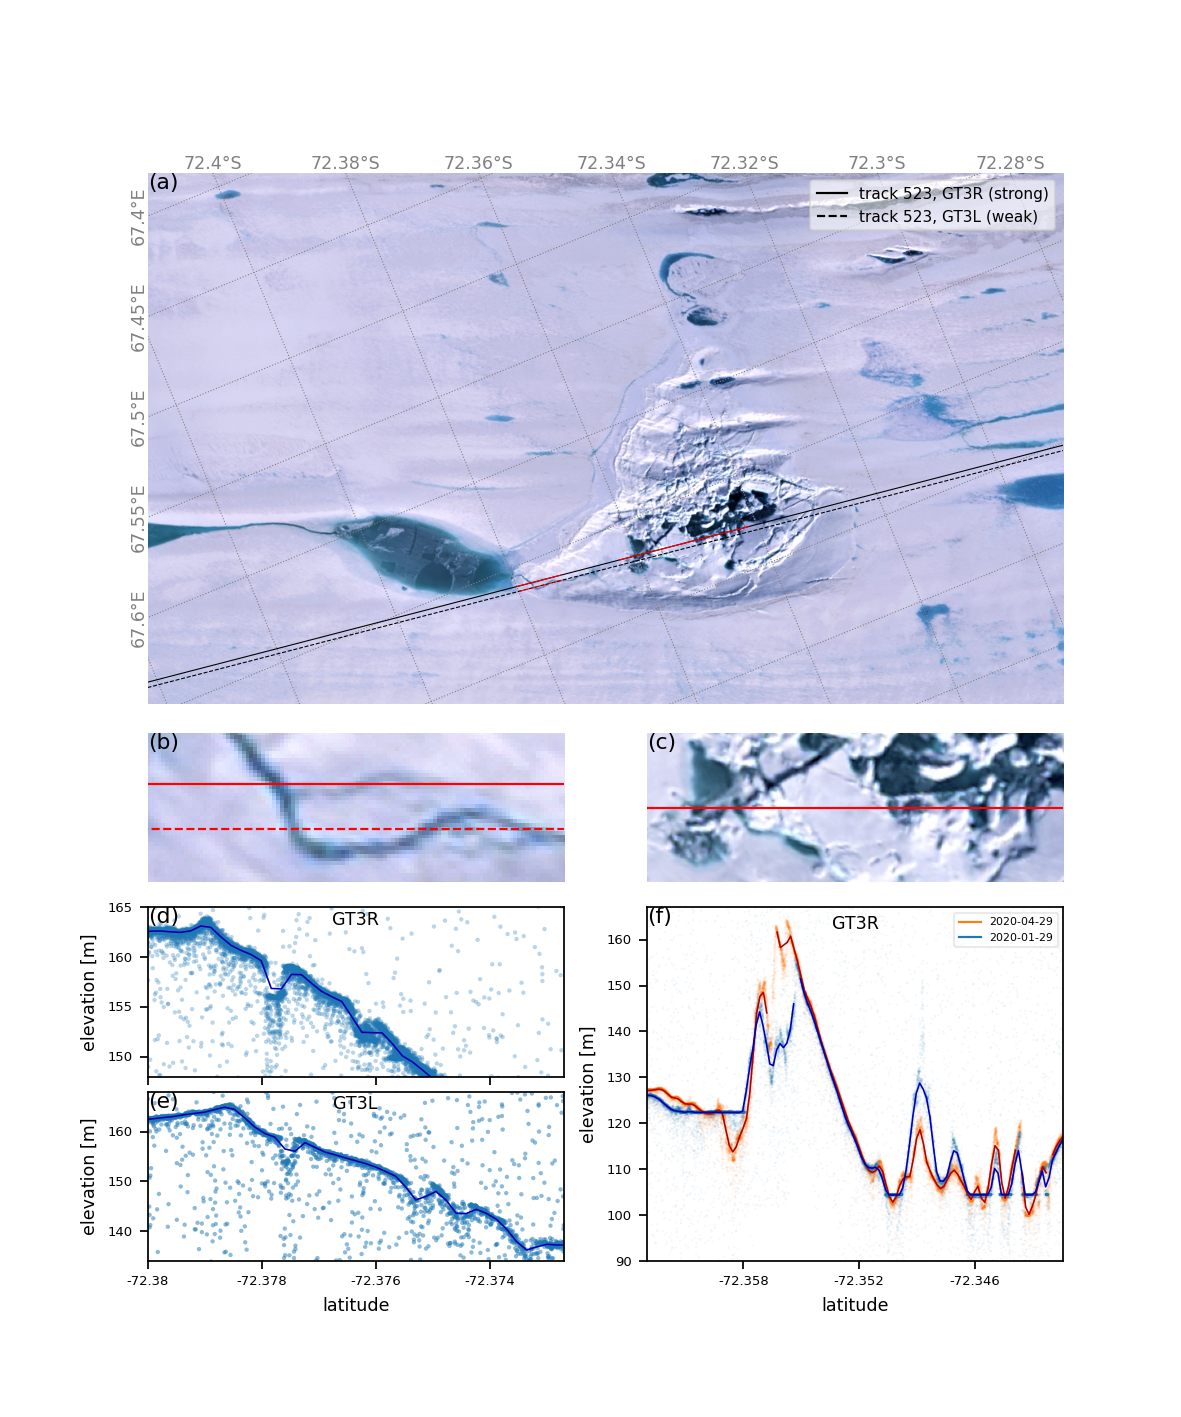

In [3]:
# saves figure at 300 dpi 
hi_res_output = False
fig_width = 7.5
fig_height = 9

fn = 'data/L8/pansharpened/LC08_L1GT_126111_20200129_20200129_01_RT_pansharp_cropped_tci_8bit_edited.tiff'
    
# make figure with grid-spec
if hi_res_output:
    fig = plt.figure(figsize=[fig_width,fig_height], constrained_layout=True, dpi=600)
else:
    fig = plt.figure(figsize=[fig_width,fig_height], constrained_layout=True)

# gridspec layout
hs = np.array([6,2,2,2])
gs = fig.add_gridspec(np.sum(hs), 2)
hs = np.cumsum(hs)
gs_full = gs[0:hs[0],:]
gs_channel_img = gs[hs[0]:hs[1],0]
gs_channel_is2 = gs[hs[1]:hs[2],0]
gs_channel_is22 = gs[hs[2]:,0]
gs_doline_img = gs[hs[0]:hs[1],1]
gs_doline_is2 = gs[hs[1]:,1]
gs_doline_is22 = gs[hs[2]:,1]

################################################################################
# FULL IMAGE OF DOLINE 
################################################################################
ax = fig.add_subplot(gs_full)
l8img = rio.open(fn)
plot.show(l8img,ax=ax)
xl = (1777609.0, 1794189.0)
yl = (731103.0, 740731.0)

# plot meridians and parallels
minlat = -72.5
maxlat = -72.0
latstep = 0.02
minlon = 67.0
maxlon = 69.2
lonstep = 0.05
meridians = np.arange(minlon,maxlon, step=lonstep)
parallels = np.arange(minlat,maxlat, step=latstep)
latseq = np.linspace(minlat,maxlat,200)
lonseq = np.linspace(minlon,maxlon,200)
gridcol = 'gray'
gridls = ':'
gridlw = 0.5
topline = [[xl[0],xl[1]],[yl[1],yl[1]]]
leftline = [[xl[0],xl[0]],[yl[0],yl[1]]]
for me in meridians:
    gr_trans = warp.transform({'init': 'epsg:4326'},l8img.crs,me*np.ones_like(latseq),latseq)
    intx,inty = intersection(leftline[0], leftline[1], gr_trans[0], gr_trans[1])
    if len(intx) > 0:
        intx = intx[0]
        inty = inty[0]
        deglab = '%.10g°E' % me
        ax.text(intx, inty, deglab, fontsize=8, color='gray',verticalalignment='center',horizontalalignment='right',
                rotation='vertical')
    thislw = gridlw
    ax.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
for pa in parallels:
    gr_trans = warp.transform({'init': 'epsg:4326'},l8img.crs,lonseq,pa*np.ones_like(lonseq))
    thislw = gridlw
    deglab = '%.10g°S' % np.abs(pa)
    intx,inty = intersection(topline[0], topline[1], gr_trans[0], gr_trans[1])
    if len(intx) > 0:
        intx = intx[0]
        inty = inty[0]
        ax.text(intx, inty, deglab, fontsize=8, color='gray',verticalalignment='bottom',horizontalalignment='center')
    ax.plot(gr_trans[0],gr_trans[1],c=gridcol,ls=gridls,lw=thislw)
    
# plot ICESat-2 ground track in imagery CRS coordinates
ax.plot(dfs6[0].x_img, dfs6[0].y_img, c='k', ls='-', lw=0.5)
ax.plot(dfs6[1].x_img, dfs6[1].y_img, c='k', ls='--', lw=0.5)
h1, = ax.plot([0,0],[1,1], c='k', ls='-', lw=1, label='track 523, GT3R (strong)')
h2, = ax.plot([0,0],[1,1], c='k', ls='--', lw=1, label='track 523, GT3L (weak)')
ax.legend(handles=[h1,h2],loc='upper right',fontsize=7,framealpha=0.6)

# set limits 
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.axis('off')

# add letter 
ax.text(0,1,'(a)',transform = ax.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black',bbox=dict(boxstyle='square,pad=1', fc='none', ec='none'))

################################################################################
# ATL03 AND ATL06 DATA PLOTS
################################################################################
labsz = 8
ticksz = 6

latlims_ch = (-72.38, -72.3727)
hlims_ch_strong = (148, 165)
hlims_ch_weak = (134, 168)
latlims_do = (-72.363, -72.3414)
hlims_do = (90, 167)

letters = 'defg'
latlims = [latlims_ch, latlims_ch, latlims_do, latlims_do]
hlims = [hlims_ch_strong, hlims_ch_weak, hlims_do, hlims_do]
gss = [gs_channel_is2, gs_channel_is22, gs_doline_is2, gs_doline_is22]
spots = ['GT3R','GT3L','GT3R','GT3L']
photalpha = [0.3,0.5,0.05,0.2]
szs = [4,4,1,1]
# [0,2], [1,3], [0,2], [1,3]
lss = ['-','--','-']

for i in range(3):
    
    axs2 = fig.add_subplot(gss[i])
    latl = latlims[i]
    hl = hlims[i]
    
    # highlight shown pieces on ground track plot
    df06 = dfs6[i%2]
    dfgt = df06[(df06.lat>latl[0]) & (df06.lat<latl[1])].copy()
    ax.plot(dfgt.x_img,dfgt.y_img,lw=0.5,c='r',ls=lss[i])
    
    
    c3 = ['C0','C1']
    c6 = ['b', 'r']
    c6 = [(0,0,0.7),(0.7,0,0)]
    lat_adv = [0.0, 0.00122] # totally eyeballing this yo deadline be rough
    
    hdls = []
    for k,j in enumerate([i%2+2,i%2]):
        if (i > 1) | (k == 1):
            df03 = dfs3[j].copy()
            df03.lat -= lat_adv[1-k]
            dfch = df03[(df03.lat>latl[0]) & (df03.lat<latl[1])].copy()
            axs2.scatter(dfch.lat,dfch.h, s=szs[i], c=c3[1-k], alpha=photalpha[i], edgecolors='none')
    for k,j in enumerate([i%2+2,i%2]):
        if (i > 1) | (k == 1):
            df06 = dfs6[j]
            axs2.plot(df06.lat-lat_adv[1-k],df06.h,lw=0.75,c=c6[1-k])
            dt = dates[1-k]
            dt = '%s-%s-%s' % (dt[:4],dt[4:6],dt[6:])
            hdl, = axs2.plot([0,0],[1,1],lw=1,c=c3[1-k],label=dt)
            hdls.append(hdl)
    
    if i == 2:
        axs2.legend(handles=hdls,loc='upper right',fontsize=5,framealpha=0.4)
    axs2.tick_params(axis='both', which='major', labelsize=ticksz)
    axs2.set_xlim(latl)
    axs2.set_ylim(hl)
    
    axs2.text(0,1,'(%s)' % letters[i],transform = axs2.transAxes,verticalalignment='top',horizontalalignment='left',
               fontsize=10, fontweight='normal',color='black')
    axs2.text(0.5,0.98,spots[i],transform = axs2.transAxes,verticalalignment='top',horizontalalignment='center',
               fontsize=8, fontweight='normal',color='black')
    
    axs2.xaxis.set_major_locator(plt.MaxNLocator(4))
    lbs = ['%g' % x for x in axs2.get_xticks()]
    axs2.set_xticklabels(lbs)
    if i>0: 
        axs2.set_xlabel('latitude',fontsize=labsz)
    else: axs2.axes.xaxis.set_ticklabels([])
    axs2.set_ylabel('elevation [m]',fontsize=labsz)

####################################################################################
# detail image for channel
axch = fig.add_subplot(gs_channel_img)
imgfn = fn
outfn = fn[:-5] + '_rotated.tiff'

# get the ground track data
lats = np.array(latlims_ch)
lons = np.interp(lats,dfs6[0].lat,dfs6[0].lon, left=np.nan, right=np.nan)

# open image and transform ground track lat/lon to image CRS
src = rio.open(imgfn)
coords_transf = warp.transform({'init': 'epsg:4326'}, src.crs, lons, lats)

# get the angle of the ground track w.r.t. the image CRS
rot_angle = np.degrees(np.arctan((coords_transf[1][1]-coords_transf[1][0])/(coords_transf[0][1]-coords_transf[0][0])))

# add rotation to the transform
src_transform = src.transform
adj_transform = A.rotation(-rot_angle)*A.translation(-src.width*0.9, +src.height/8.0)

upscale_factor = 2
data = src.read(out_shape=(
        src.count,
        int(src.height * upscale_factor),
        int(src.width * upscale_factor)
    ),
    resampling=Resampling.bilinear)

# scale image transform
transform = src.transform * src.transform.scale(
    (src.width / data.shape[-1]),
    (src.height / data.shape[-2])
)
kwargs = src.meta
src_transform = transform
adj_transform = A.rotation(-rot_angle)*A.translation(-src.width*0.2*upscale_factor, +src.height*0.125*upscale_factor)
dst_transform = transform * adj_transform
kwargs['transform'] = dst_transform
kwargs['width'] = data.shape[2]
kwargs['height'] = data.shape[1]

# reproject the image based on the rotated transform
with rio.open(outfn, 'w', **kwargs) as dst:
    for j, band in enumerate(data, 1):
        dest = np.zeros_like(band)
        reproject(
            band,
            dest,
            src_transform=src_transform,
            src_crs=src.crs,
            dst_transform=dst_transform,
            dst_crs=src.crs,
            resampling=Resampling.cubic_spline)
        dst.write(dest, indexes=j)

# open reprojected image and show in axes
thisImg = rio.open(outfn)
rgb = np.zeros((thisImg.height,thisImg.width,thisImg.count))
for j in range(thisImg.count):
    rgb[:,:,j] = thisImg.read(j+1)/255
kernel = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape((3, 3, 1))
rgbsharp = ndimage.convolve(rgb, kernel, mode='nearest')
imgsharp = np.clip(rgbsharp, 0, 1)
axch.imshow(np.flipud(imgsharp))

# transform ground track to image CRS, then to pixel coordinates of rotated image, show on plot
px = TransformMethodsMixin.index(thisImg,coords_transf[0],coords_transf[1],precision=5)
px = (list(-np.array(px[0]) + thisImg.height - 1),px[1])

# plot strong beam ground track
px_gt_strong = TransformMethodsMixin.index(thisImg,np.array(dfs6[0].x_img), np.array(dfs6[0].y_img),precision=5)
px_gt_strong = (list(-np.array(px_gt_strong[0]) + thisImg.height - 1),px_gt_strong[1])
pxx_strong = np.array(px_gt_strong[1]).astype(float)
pxy_strong = np.array(px_gt_strong[0]).astype(float)
axch.plot(pxx_strong,pxy_strong,'r-',lw=1,solid_capstyle="round")

# plot weak beam ground track
px_gt_weak = TransformMethodsMixin.index(thisImg,np.array(dfs6[1].x_img), np.array(dfs6[1].y_img),precision=5)
px_gt_weak = (list(-np.array(px_gt_weak[0]) + thisImg.height - 1),px_gt_weak[1])
pxx_weak = np.array(px_gt_weak[1]).astype(float)
pxy_weak = np.array(px_gt_weak[0]).astype(float)
axch.plot(pxx_weak,pxy_weak,'r--',lw=1,solid_capstyle="round")

# set proper the x and y limits
buffh = 0.2
buffv = 0.18
xl = px[1][0]
xu = px[1][1]
axch.set_xlim((xl,xu))
xwid = xu-xl
midy = np.mean([np.mean(pxy_strong),np.mean(pxy_weak)])
yl = - buffv * xwid + midy
yu = buffv * xwid + midy
axch.set_ylim((yl,yu))
asp = (xu-xl) / (yu-yl)
axch.axis('off')
bbox_channel = TransformMethodsMixin.xy(thisImg,[xl,xl,xu,xu,xl],[yl,yu,yu,yl,yl])
ax.plot(bbox_channel[0],bbox_channel[1],'k-',lw=0.7)

axch.text(0,1,'(b)',transform = axch.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black')

axdo = fig.add_subplot(gs_doline_img)
axdo.text(0.5,0.5,'[cropped image doline bottom]',horizontalalignment='center',verticalalignment='center')
axdo.axis('off')

####################################################################################
# detail image for interior
axdo = fig.add_subplot(gs_doline_img)
imgfn = fn
outfn = fn[:-5] + '_rotated.tiff'

# get the ground track data
lats = np.array(latlims_do)
lons = np.interp(lats,dfs6[0].lat,dfs6[0].lon, left=np.nan, right=np.nan)

# open image and transform ground track lat/lon to image CRS
src = rio.open(imgfn)
coords_transf = warp.transform({'init': 'epsg:4326'}, src.crs, lons, lats)

# get the angle of the ground track w.r.t. the image CRS
rot_angle = np.degrees(np.arctan((coords_transf[1][1]-coords_transf[1][0])/(coords_transf[0][1]-coords_transf[0][0])))

# open reprojected image and show in axes (here with some sharpening)
thisImg = rio.open(outfn)
rgb = np.zeros((thisImg.height,thisImg.width,thisImg.count))
for j in range(thisImg.count):
    rgb[:,:,j] = np.power(thisImg.read(j+1)/255,0.7)
kernel = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape((3, 3, 1))
rgbsharp = ndimage.convolve(rgb, kernel, mode='nearest')
imgsharp = np.clip(rgbsharp, 0, 1)
axdo.imshow(np.flipud(imgsharp))

# transform ground track to image CRS, then to pixel coordinates of rotated image, show on plot
px = TransformMethodsMixin.index(thisImg,coords_transf[0],coords_transf[1],precision=5)
px = (list(-np.array(px[0]) + thisImg.height - 1),px[1])

# plot strong beam ground track
px_gt_strong = TransformMethodsMixin.index(thisImg,np.array(dfs6[0].x_img), np.array(dfs6[0].y_img),precision=5)
px_gt_strong = (list(-np.array(px_gt_strong[0]) + thisImg.height - 1),px_gt_strong[1])
pxx_strong = np.array(px_gt_strong[1]).astype(float)
pxy_strong = np.array(px_gt_strong[0]).astype(float)
axdo.plot(pxx_strong,pxy_strong,'r-',lw=1,solid_capstyle="round")

# plot weak beam ground track
px_gt_weak = TransformMethodsMixin.index(thisImg,np.array(dfs6[1].x_img), np.array(dfs6[1].y_img),precision=5)
px_gt_weak = (list(-np.array(px_gt_weak[0]) + thisImg.height - 1),px_gt_weak[1])
pxx_weak = np.array(px_gt_weak[1]).astype(float)
pxy_weak = np.array(px_gt_weak[0]).astype(float)

# set proper the x and y limits
xl = px[1][0]
xu = px[1][1]
axdo.set_xlim((xl,xu))
xwid = xu-xl
yl = - buffv * xwid + px[0][0]
yu = buffv * xwid + px[0][0]
axdo.set_ylim((yl,yu))
asp = (xu-xl) / (yu-yl)
axdo.axis('off')
bbox_doline = TransformMethodsMixin.xy(thisImg,[xl,xl,xu,xu,xl],[yl,yu,yu,yl,yl])
ax.plot(bbox_doline[0],bbox_doline[1],'k-',lw=0.7)

# add letter 
axdo.text(0,1,'(c)',transform = axdo.transAxes,verticalalignment='top',horizontalalignment='left',
           fontsize=10, fontweight='normal',color='black')

if hi_res_output:
    plt.savefig('figs/Fig3_first_melt_season_after_doline_formation.jpg')